In [ ]:
pip install dcor --quiet

In [ ]:
pip install omegaconf --quiet

In [ ]:
import json
import math
import os
import pandas as pd
import torch
import time as time
from omegaconf import OmegaConf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
# Read pickles from the path specified in config.dest_file
config_path = "config.yaml"  # Replace with the path to your config file
config = OmegaConf.load(config_path)
df_encoded_path = os.path.join(config.dest_file, "df_encoded.csv")
# Load the DataFrame from the CSV file
df = pd.read_csv(df_encoded_path)

In [ ]:
# keep only 20% of the data for faster computation
df_small = df.sample(frac=0.2, random_state=42).reset_index(drop=False)

In [ ]:
df_small.describe()

In [ ]:
df_encoded = df

In [ ]:
feature_column = ['surfaceProcessingLocationCavity', 'hotRunner', 'hotRunnerCost',
       'manufacturingCost', 'mouldValidationCost', 'designTime',
       'hourlyDesignCost', 'removedChassis', 'weightChassisProcessed',
       'surfaceProcessingLocationChassis', 'removedCavity', 'numberOfCavities',
       'weightCavityProcessed', 'weightMould', 'totalTransportationPercentage',
       'percentageAircraft', 'percentageLorry', 'percentageTrain',
       'percentageShip', 'totalDistance', 'transportCost',
       'injectedMaterial_product', 'injectedMaterialCost',
       'percentageRecycledMaterial', 'maxDepth', 'maxWallThickness',
       'productVolume', 'materozzaVolume', 'nAnniProduzione', 'nProdottiAnno',
       'materialDensity', 'tolerance', 'surfaceFinishing', 'cycleTime',
       'machineCycleTime', 'maintenanceCost', 'productionCost',
       'injectedMaterial_materozza', 'injectionMouldingProcess',
       'memtiEngineValue', 'steelPrice', 'runnersType', 'mouldMaterialName',
       'machineName', 'EUUSMacchina', 'CNMacchina', 'gateDiameter',
       'setupTime', 'warmupTime', 'deliveryVolume', 'deliveryPeriod',
       'mouldDesignCostDisplay', 'mouldTotalCost']

target_column = ['Cost',
       'human health - photochemical oxidation',
       'ecosystem quality - terrestrial ecotoxicity',
       'resources - mineral extraction', 'resources - non-renewable energy',
       'ecosystem quality - terrestrial acidification & nutrification',
       'resources - total', 'human health - ionising radiation',
       'human health - respiratory effects (inorganics)',
       'human health - total', 'human health - human toxicity',
       'ecosystem quality - aquatic ecotoxicity',
       'climate change - climate change',
       'human health - ozone layer depletion',
       'ecosystem quality - land occupation', 'climate change - total',
       'ecosystem quality - total']

From the above table, we know hat most of the target variables having distance correlation=1 are redundant or used for deriving the final variables. Hence it is good to eliminate them and keep only four ['human health - total', 'ecosystem quality - total', 'resources - total', 'Cost']

In [ ]:
input_variables= ['surfaceProcessingLocationCavity', 'hotRunner',
'hotRunnerCost','manufacturingCost', 'mouldValidationCost',
'designTime','hourlyDesignCost', 'removedChassis', 'weightChassisProcessed',
'surfaceProcessingLocationChassis', 'removedCavity', 'numberOfCavities',
'weightCavityProcessed', 'weightMould',
'totalTransportationPercentage','percentageAircraft', 'percentageLorry', 'percentageTrain','percentageShip', 'totalDistance',
'injectedMaterial_product', 'injectedMaterialCost','percentageRecycledMaterial', 'maxDepth', 'maxWallThickness','productVolume', 'materozzaVolume', 'nAnniProduzione', 'nProdottiAnno',
 'materialDensity', 'tolerance', 'surfaceFinishing', 'cycleTime',
'machineCycleTime',
'maintenanceCost', 'productionCost','transportCost', 'mouldTotalCost',
'injectedMaterial_materozza', 'injectionMouldingProcess','memtiEngineValue', 'steelPrice', 'runnersType', 'mouldMaterialName',
'machineName', 'EUUSMacchina', 'CNMacchina', 'gateDiameter', 'setupTime', 'warmupTime', 'deliveryVolume', 'deliveryPeriod','mouldDesignCostDisplay']

output_variables= ['human health - total', 
                   'ecosystem quality - total',
                    'resources - total', 
                      'Cost']

In [ ]:
thr = float(np.clip(X[0], 0.0, 1.0))


In [86]:
"""
Refactored Variable Partitioned Bayesian Optimization (VPBO) pipeline.

Highlights:
- Clean scaling/descaling with internal methods (_scale/_descale) — no shadowing.
- Robust batching for joblib. No tuple-dtype arrays.
- Safer shape handling in LCB acquisition and GP predictions.
- Reference model is pluggable; default returns zeros with correct shape.
- MLP evaluator with distance correlation-based feature filtering and safe bounds.
- Clear logging and error handling for stability.

Notes:
- Replace `df_small` with your actual DataFrame if needed, or pass your own evaluator to BO.
- This file is designed to be imported OR run. The example usage at the bottom is optional.
"""

from __future__ import annotations
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
from typing import Callable, Dict, Tuple, Optional, List

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from scipy.optimize import minimize, Bounds
from joblib import Parallel, delayed
import sklearn.gaussian_process as gpr

import dcor
import torch
import time

# ------------------------------
# Utility: distance correlation filter
# ------------------------------

def dcor_filter(x: np.ndarray, y: np.ndarray, threshold: float, min_features=5):
    corr = np.array([dcor.distance_correlation(x[:, i], y) for i in range(x.shape[1])])
    mask = corr >= threshold
    
    # Ensure at least min_features are kept
    if np.sum(mask) < min_features:
        top_indices = np.argsort(corr)[-min_features:]
        mask[:] = False
        mask[top_indices] = True

    return x[:, mask], mask, corr

def sample_thresholds(X, Y):
    MaxThrs = np.max([dcor.distance_correlation(X[:, i], Y.mean(axis=1)) for i in range(X.shape[1])])
    
    # Fine grid for low threshold
    low_grid = np.arange(0.04, 0.1+1e-6, 0.005)
    
    # Coarse grid for high threshold
    high_grid = np.arange(0.1, MaxThrs+1e-6, 0.1)
    
    # Combine, remove duplicates if 0.1 appears twice
    thresholds = np.unique(np.concatenate([low_grid, high_grid]))
    return thresholds


# ------------------------------
# Evaluator: MLP with feature filtering
# ------------------------------

def mlp_eval(x_batch: np.ndarray, *args) -> List[List[float]]:
    """Evaluate a batch of x points.

    x contains two variables per point:
      x[0] -> threshold in [0, 1]
      x[1] -> hidden-size proxy in [0, 1] mapped to [10, 200]

    Returns a list of [score] for each x (lower is better).
    """
    X_full, y_full = args
    results: List[List[float]] = []

    # weights for scalarization
    alpha = 0.5  # reward on higher threshold
    beta = 0.5   # penalty on prediction error

    x_batch = np.atleast_2d(x_batch)

    for x in x_batch:
        thr = float(np.clip(x[0], 0.0, 1.0))
        hidden_size = int(np.clip(x[1], 0.0, 1.0) * (200 - 10) + 10)

        X_tr, X_val, y_tr, y_val = train_test_split(X_full, y_full, test_size=0.2, random_state=0)

        X_sel, selected, corr = dcor_filter(X_tr, y_tr, thr)
        if X_sel.shape[1] == 0:
            # No features selected — heavy penalty
            results.append([1e6])
            continue

        X_val_sel = X_val[:, selected]

        model = MLPRegressor(hidden_layer_sizes=(hidden_size,), max_iter=30, random_state=0)
        try:
            model.fit(X_sel, y_tr)
            y_pred = model.predict(X_val_sel)
            error = median_squared_error(y_val, y_pred)
        except Exception:
            # If training fails, assign a large error
            error = 1e6

        score = beta * float(error) - alpha * thr
        print(f"[Eval] thr={thr:.3f}, hidden={hidden_size}, k={len(selected)}, MRE={float(error):.6f}, score={score:.6f}")
        results.append([score])

    return results


# ------------------------------
# Reference model utilities
# ------------------------------

def ref_model(x_batch: np.ndarray, splits: int) -> np.ndarray:
    """Default reference model for VPBO. Returns zeros with shape (n_points, splits)."""
    x_batch = np.atleast_2d(x_batch)
    return np.zeros((x_batch.shape[0], int(splits)), dtype=float)


# ------------------------------
# Acquisition Function: Lower Confidence Bound (LCB)
# ------------------------------

class LCB_AF:
    def __init__(self,
                 model: GaussianProcessRegressor,
                 dim: int,
                 exp_w: float,
                 descale_fn: Callable[[np.ndarray], np.ndarray],
                 refmod: Optional[Callable] = None,
                 args: Tuple = ()): 
        self.model = model
        self.dim = int(dim)
        self.exp_w = float(exp_w)
        self._descale = descale_fn
        self.args = args
        self.refmod = refmod if refmod is not None else (lambda *a, **k: 0.0)

    def __call__(self, x: np.ndarray) -> float:
        """Compute LCB at x for optimizer-friendly signature."""
        return float(self.LCB(x))

    def LCB(self, x: np.ndarray) -> float:
        x = np.atleast_2d(x)
        if x.shape[1] != self.dim:
            x = x.reshape(-1, self.dim)

        mu, std = self.model.predict(x, return_std=True)
        mu = mu.reshape(-1)
        std = std.reshape(-1)

        # Reference term
        if callable(self.refmod):
            try:
                # Allow torch-based nets or numpy callables
                yref = self.refmod(torch.from_numpy(x).float(), *self.args) if _looks_like_torch_model(self.refmod) else self.refmod(self._descale(x), *self.args)
                if isinstance(yref, torch.Tensor):
                    yref = yref.detach().cpu().numpy()
                yref = np.atleast_1d(yref).reshape(-1)
            except Exception:
                yref = np.zeros_like(mu)
        else:
            yref = np.zeros_like(mu)

        # Standard LCB (to be minimized)
        val = yref + mu - self.exp_w * std
        return float(np.atleast_1d(val).reshape(-1)[0])


def _looks_like_torch_model(obj) -> bool:
    # Heuristic: torch.nn.Module or callable expecting tensors
    return hasattr(obj, 'parameters') or isinstance(obj, torch.nn.Module)


# ------------------------------
# VPBO core
# ------------------------------

class BO:
    def __init__(self,
                 distmod: Callable[[np.ndarray, Tuple], List[List[float]]],
                 args: Tuple,
                 dist_ref: Dict,
                 ref_args: Tuple,
                 dim: int,
                 bounds: Bounds,
                 kernel: Optional[gpr.kernels.Kernel] = None,
                 exp_w: float = 2.0,
                 ub: Optional[np.ndarray] = None,
                 lb: Optional[np.ndarray] = None,
                 system: str = 'default'):
        self.distmod = distmod
        self.args = args
        self.dist_ref = dist_ref or {}
        self.ref_args = ref_args
        self.dim = int(dim)
        self.bounds = bounds
        self.kernel = kernel if kernel is not None else (C(1.0, (1e-3, 1e3)) * RBF(length_scale=np.ones(dim)))
        self.exp_w = float(exp_w)
        self.ub = np.array(ub) if ub is not None else np.ones(dim)
        self.lb = np.array(lb) if lb is not None else np.zeros(dim)
        self.system = system

        # Sanity checks
        assert self.ub.shape == (self.dim,) and self.lb.shape == (self.dim,), "lb/ub must match dim"

    # ----- scaling helpers -----
    def _descale(self, x: np.ndarray) -> np.ndarray:
        """Map from [bounds.lb, bounds.ub] -> [lb, ub] (real space)."""
        x = np.asarray(x, dtype=float)
        m = (self.ub - self.lb) / (self.bounds.ub - self.bounds.lb)
        b = self.ub - m * self.bounds.ub
        return m * x + b

    def _scale(self, x: np.ndarray, *, lb: Optional[np.ndarray] = None, ub: Optional[np.ndarray] = None) -> np.ndarray:
        """Map from [lb, ub] -> [bounds.lb, bounds.ub]."""
        x = np.asarray(x, dtype=float)
        lom = self.lb if lb is None else np.asarray(lb, dtype=float)
        upm = self.ub if ub is None else np.asarray(ub, dtype=float)
        m = (self.bounds.ub - self.bounds.lb) / (upm - lom)
        b = self.bounds.ub - m * upm
        return m * x + b

    # ----- main optimizer -----
    def optimizer_vpbo(self,
                       trials: int,
                       split_num: int,
                       lim_init: float,
                       f_cores: int = 1,
                       af_cores: int = 1,
                       ref_cores: int = 1,
                       x_init: Optional[np.ndarray] = None) -> None:
        print('Variable Partitioned BO run...')
        start = time.time()
        self.trials_vp = int(trials)
        splits = int(split_num)
        if self.trials_vp <= 0 or splits <= 0:
            raise ValueError("trials and split_num must be positive integers")

        self.time_vp = np.zeros(self.trials_vp)
        self.time_fvp = np.zeros(self.trials_vp)
        div = int(self.dim / splits)
        if self.dim % splits != 0:
            raise ValueError("dim must be divisible by split_num for equal partitions")

        ref_mod = self.dist_ref.get('distrefmod', None)

        # --------- Initial design per-split ---------
        x = lim_init * np.ones((splits, self.dim))
        lwr = x.copy()
        upr = x.copy() + 1e-6

        for i in range(splits):
            if x_init is None:
                rand_block = np.random.uniform(self.bounds.lb[i], self.bounds.ub[i], size=(div,))
                x[i, i*div:(i+1)*div] = rand_block
            else:
                x_init = np.atleast_2d(x_init)
                x[i, i*div:(i+1)*div] = x_init[0, i*div:(i+1)*div]
            # set bounds for this split
            lwr[i, i*div:(i+1)*div] = self.bounds.lb[i]
            upr[i, i*div:(i+1)*div] = self.bounds.ub[i]

        # Append a global row as in original code (shared coordinates filled later)
        x = np.vstack([x, lim_init * np.ones((1, self.dim))])

        init_pts = int(len(x) / splits)
        init_pts = max(1, init_pts)

        # Batch for evaluation
        def _batch_array(arr: np.ndarray, n_parts: int) -> List[np.ndarray]:
            if n_parts <= 1:
                return [arr]
            parts: List[np.ndarray] = []
            chunk = int(np.ceil(arr.shape[0] / n_parts))
            for i in range(n_parts):
                sl = arr[i*chunk:(i+1)*chunk]
                if sl.size:
                    parts.append(sl)
            return parts

        x_batches = _batch_array(x, f_cores)

        start_f = time.time()
        y_list = Parallel(n_jobs=f_cores)(delayed(self.distmod)(self._descale(xb), *self.args) for xb in x_batches)

        # Evaluate reference model
        def _eval_ref(x_eval: np.ndarray) -> np.ndarray:
            if _looks_like_torch_model(ref_mod):
                # torch path, compute per-row
                out = Parallel(n_jobs=ref_cores, backend="loky")(delayed(ref_mod)(torch.from_numpy(row.reshape(1, -1)).float(), *self.ref_args) for row in x_eval)
                out = [o.detach().cpu().numpy() if isinstance(o, torch.Tensor) else np.asarray(o) for o in out]
                out = np.vstack(out)
                return out.reshape(out.shape[0], -1)
            elif callable(ref_mod):
                parts = _batch_array(x_eval, ref_cores)
                outs = Parallel(n_jobs=ref_cores, backend="loky")(delayed(ref_mod)(self._descale(pb), *self.ref_args) for pb in parts)
                return np.vstack(outs)
            else:
                # default zeros with splits columns
                return ref_model(x_eval, splits)

        y_ref = _eval_ref(x)
        end_f = time.time()
        self.time_fvp[0] = end_f - start_f

        # Normalize y_list to array
        y = np.vstack([np.atleast_2d(np.asarray(yy)) for yy in y_list])
        if y.ndim == 1:
            y = y.reshape(-1, 1)

        eps = y - y_ref
        y_bst = np.min(y, axis=0).reshape(1, -1)

        # Prepare GP models and split-specific bounds
        bnds_var: Dict[str, Bounds] = {}
        model_vp: Dict[str, GaussianProcessRegressor] = {}
        LCBs: Dict[str, LCB_AF] = {}

        for i in range(splits):
            print(f'Fitting initial GP for split {i+1}...')
            gp = GaussianProcessRegressor(self.kernel, alpha=1e-6, n_restarts_optimizer=5, normalize_y=True, random_state=0)
            gp.fit(x, eps[:, i])
            model_vp[str(i+1)] = gp

            # Start lwr/upr around the best point for split i
            best_idx = int(np.argmin(y[:, i]))
            lwr[i] = x[best_idx]
            lwr[i, i*div:(i+1)*div] = self.bounds.lb[i]
            upr[i] = x[best_idx] + 1e-6
            upr[i, i*div:(i+1)*div] = self.bounds.ub[i]
            bnds_var[str(i+1)] = Bounds(lwr[i], upr[i])

            LCBs[str(i+1)] = LCB_AF(model_vp[str(i+1)], self.dim, self.exp_w, self._descale, self.dist_ref.get('distrefmod'+str(i+1)), self.ref_args)

        restarts = max(8, int(round(128 / (splits + 1), 0)))
        x_next = x.copy()

        end = time.time()
        for i in range(init_pts):
            self.time_vp[i] = (i+1) * (end - start) / init_pts
            self.time_fvp[i] = (i+1) * (end_f - start_f) / init_pts

        print(f'ITERATION COUNT IS AT {init_pts}; TOTAL ELAPSED TIME: {self.time_vp[init_pts-1]:.2f}s')
        self.time_vp[0] = time.time() - start

        # --------- Main BO loop ---------
        for it in range(self.trials_vp - init_pts):
            x0 = np.random.uniform(self.bounds.lb, self.bounds.ub, size=(restarts, self.dim))
            # Optimize each split LCB
            for j in range(splits):
                opts = Parallel(n_jobs=af_cores, backend="loky")(delayed(minimize)(LCBs[str(j+1)], x_start, method='L-BFGS-B', bounds=bnds_var[str(j+1)]) for x_start in x0)
                cand = np.array([res.x for res in opts], dtype=float)
                vals = np.array([float(np.atleast_1d(res.fun)[0]) if np.ndim(res.fun) else float(res.fun) for res in opts])
                best = cand[int(np.argmin(vals))]
                x_next[j] = best
                # shared block coordinates
                x_next[-1, j*div:(j+1)*div] = best[j*div:(j+1)*div]

            # Evaluate batch
            x_batches_next = _batch_array(x_next, f_cores)
            start_f = time.time()
            y_next_list = Parallel(n_jobs=f_cores, backend="loky")(delayed(self.distmod)(self._descale(xb), *self.args) for xb in x_batches_next)
            y_next = np.vstack([np.atleast_2d(np.asarray(yy)) for yy in y_next_list])
            if y_next.ndim == 1:
                y_next = y_next.reshape(-1, 1)

            y_ref_next = _eval_ref(x_next)
            end_f = time.time()
            self.time_fvp[it+init_pts] = self.time_fvp[max(0, it+init_pts-1)] + (end_f - start_f)

            # Update datasets
            x = np.vstack([x, x_next])
            y = np.vstack([y, y_next])
            eps_next = y_next - y_ref_next
            eps = np.vstack([eps, eps_next])
            y_bst = np.vstack([y_bst, np.min(y_next, axis=0).reshape(1, -1)])

            # Update bounds around new bests and refit GPs
            for j in range(splits):
                if np.any(y_next[:, j] < np.min(y[:-y_next.shape[0], j])):
                    best_idx = int(np.argmin(y_next[:, j]))
                    lwr[j] = x_next[best_idx]
                    lwr[j, j*div:(j+1)*div] = self.bounds.lb[j]
                    upr[j] = x_next[best_idx] + 1e-6
                    upr[j, j*div:(j+1)*div] = self.bounds.ub[j]
                model_vp[str(j+1)].fit(x, eps[:, j])
                bnds_var[str(j+1)] = Bounds(lwr[j], upr[j])

            self.time_vp[it+init_pts] = time.time() - start
            print(f'ITERATION COUNT IS AT {init_pts + it + 1}; TOTAL ELAPSED TIME: {self.time_vp[it+init_pts]:.2f}s')

        # Save results
        self.vpbo_optim = True
        self.model_vp = model_vp
        self.x_vp = self._descale(x)
        self.y_vp = y
        self.y_vpbst = y_bst


# ------------------------------
# Example Usage (commented)
# ------------------------------

if __name__ == "__main__":
    # --- Replace this with your actual data ---

    target_cols = ['human health - total', 
                   'ecosystem quality - total',
                    'resources - total', 
                      'Cost']  # <-- put your real target columns here

    evaluator = lambda x: mlp_eval(x, X, Y)
    # Example synthetic usage. Replace with your data/evaluator as needed.
    np.random.seed(42)

    
    X_raw = df_small[selected_features].values
    Y_raw = df_small[target_column].values

    scaler_x = MinMaxScaler()
    X_scaled = scaler_x.fit_transform(X_raw)

    scaler_y = MinMaxScaler()
    Y_scaled = scaler_y.fit_transform(Y_raw)

    # Wrap evaluator to match the BO signature (returns list-of-lists or array)
    def evaluator(xb: np.ndarray, X=X_scaled, Y=Y_scaled):
        return np.asarray(mlp_eval(xb, X, Y))

    # Reference model dict (optional); here we use zeros via default
    dist_ref = { 'distrefmod': None,
                'distrefmod1': None }  # can also provide 'distrefmod1', 'distrefmod2', ... per split

    dim = 2  # [threshold, hidden_size_proxy]
    bounds = Bounds(lb=np.zeros(dim), ub=np.ones(dim))
    kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=np.ones(dim))

    bo = BO(distmod=evaluator,
            args=(),
            dist_ref=dist_ref,
            ref_args=(),
            dim=dim,
            bounds=bounds,
            kernel=kernel,
            exp_w=2.0,
            ub=np.ones(dim),
            lb=np.zeros(dim),
            system='default')

    # Run VPBO: 10 trials, 2 splits (dim must be divisible by splits), lim_init=0.5
    bo.optimizer_vpbo(trials=10, split_num=1, lim_init=0.5, f_cores=1, af_cores=1, ref_cores=1)

    # Results
    print("Best observed per-iteration:", bo.y_vpbst[:5], "...")
    print("Final dataset shapes:", bo.x_vp.shape, bo.y_vp.shape)


Variable Partitioned BO run...


KeyboardInterrupt: 

In [91]:
bo.y_vp.shape

AttributeError: 'BO' object has no attribute 'y_vp'

In [ ]:
#%% BO setup
ub = np.array([423, 423])
lb = np.array([303, 303])
exp_w = [2.6]
kernel = gpr.kernels.Matern(np.ones(2), np.array([[1e-1, 1e3]]*dim), nu = 2.5)
bounds = Bounds(np.zeros(dim), np.ones(dim))
x_init = np.linspace(bounds.lb, bounds.ub, 5)
x_init = np.meshgrid(*x_init.T)
x_init = np.reshape(x_init, (dim, -1)).T
for i, x_0 in enumerate(x_init):
    print(f"Initial point {i}: {x_0}")

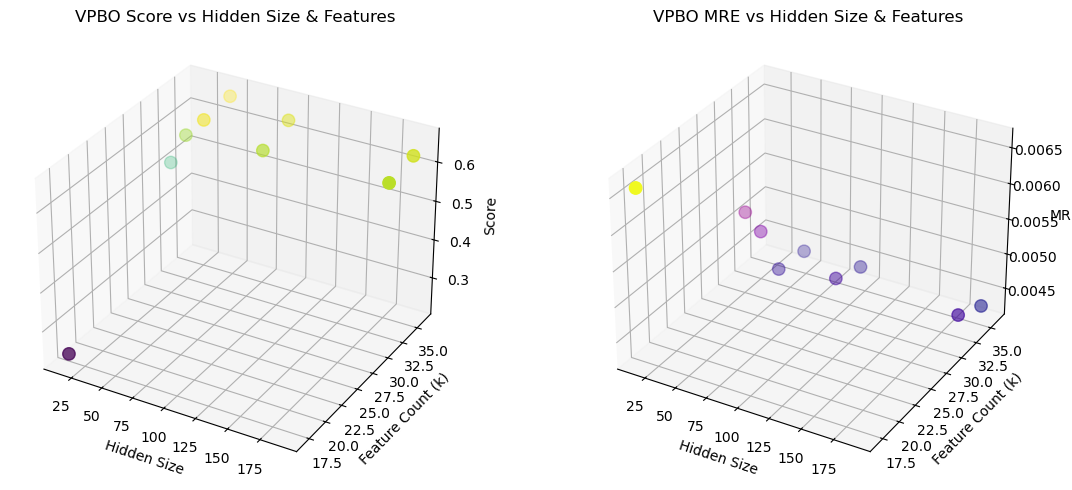

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Extracted log data: [hidden_size, k (features), thr, score, MRE]
data = np.array([
    [28, 32, 0.04, 0.5939, 0.00488],
    [43, 36, 0.04, 0.6539, 0.00434],
    [91, 32, 0.04, 0.6072, 0.00451],
    [190, 36, 0.04, 0.6235, 0.00429],
    [15, 32, 0.1, 0.5124, 0.00510],
    [43, 32, 0.1, 0.6450, 0.00440],
    [91, 36, 0.1, 0.6310, 0.00435],
    [190, 32, 0.1, 0.6105, 0.00450],
    [15, 17, 0.2, 0.2339, 0.0066],
    
])

hidden_size = data[:,0]
k_features = data[:,1]
score = data[:,3]
mre = data[:,4]

# 3D scatter plot for score vs hidden size and features
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,2,1, projection='3d')
ax1.scatter(hidden_size, k_features, score, c=score, cmap='viridis', s=80)
ax1.set_xlabel('Hidden Size')
ax1.set_ylabel('Feature Count (k)')
ax1.set_zlabel('Score')
ax1.set_title('VPBO Score vs Hidden Size & Features')

ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.scatter(hidden_size, k_features, mre, c=mre, cmap='plasma', s=80)
ax2.set_xlabel('Hidden Size')
ax2.set_ylabel('Feature Count (k)')
ax2.set_zlabel('MRE')
ax2.set_title('VPBO MRE vs Hidden Size & Features')

plt.tight_layout()
plt.show()


In [ ]:

selected_features = [
    'surfaceProcessingLocationCavity', 'hotRunner', 'hotRunnerCost',
    'manufacturingCost', 'mouldValidationCost', 'designTime',
    'hourlyDesignCost', 'removedChassis', 'weightChassisProcessed',
    'surfaceProcessingLocationChassis', 'removedCavity', 'numberOfCavities',
    'weightCavityProcessed', 'weightMould', 'totalDistance',
    'injectedMaterial_product', 'injectedMaterialCost',
    'percentageRecycledMaterial', 'maxDepth', 'maxWallThickness',
    'productVolume', 'materozzaVolume', 'nProdottiAnno', 'materialDensity',
    'tolerance', 'surfaceFinishing', 'machineCycleTime', 'maintenanceCost',
    'productionCost', 'injectedMaterial_materozza',
    'injectionMouldingProcess', 'steelPrice', 'mouldMaterialName',
    'machineName', 'EUUSMacchina', 'CNMacchina', 'setupTime',
    'deliveryVolume', 'deliveryPeriod'
]

target_column = ['Cost', 'resources - total', 'human health - total', 'ecosystem quality - total']

# Main

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process.kernels import RBF
from scipy.optimize import Bounds
import dcor
from joblib import Parallel, delayed
import time
from sklearn.gaussian_process import GaussianProcessRegressor
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np
from matplotlib import pyplot as pyp
from scipy.optimize import minimize, Bounds, NonlinearConstraint
from joblib import Parallel, delayed
import sklearn.gaussian_process as gpr
from collections import OrderedDict
import torch
import time

# 1. Load your dataframe
df = df_small #pd.read_csv(df_encoded_path) # <- replace with actual path
np.random.seed(42)

# 2. Select features and target

selected_features = [
    'surfaceProcessingLocationCavity', 'hotRunner', 'hotRunnerCost',
    'manufacturingCost', 'mouldValidationCost', 'designTime',
    'hourlyDesignCost', 'removedChassis', 'weightChassisProcessed',
    'surfaceProcessingLocationChassis', 'removedCavity', 'numberOfCavities',
    'weightCavityProcessed', 'weightMould', 'totalDistance',
    'injectedMaterial_product', 'injectedMaterialCost',
    'percentageRecycledMaterial', 'maxDepth', 'maxWallThickness',
    'productVolume', 'materozzaVolume', 'nProdottiAnno', 'materialDensity',
    'tolerance', 'surfaceFinishing', 'machineCycleTime', 'maintenanceCost',
    'productionCost', 'injectedMaterial_materozza',
    'injectionMouldingProcess', 'steelPrice', 'mouldMaterialName',
    'machineName', 'EUUSMacchina', 'CNMacchina', 'setupTime',
    'deliveryVolume', 'deliveryPeriod'
]

target_column = ['Cost', 'resources - total', 'human health - total', 'ecosystem quality - total']


# 3. Split the data into features and target and scale them

X_raw = df[selected_features].values
Y_raw = df[target_column].values

scaler_x = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X_raw)

scaler_y = MinMaxScaler()
Y_scaled = scaler_y.fit_transform(Y_raw)

def dcor_filter(X, y, threshold):
    print("Shape of y:", y.shape)  # Add this line for debugging
    selected = []
    for i in range(X.shape[1]):
        corr = np.mean([dcor.distance_correlation(X[:, i], y[:, j]) for j in range(y.shape[1])])
        if corr >= threshold:
            selected.append(i)
    return X[:, selected], selected





# MLP evaluator for multiple targets with threshold maximization + error minimization
def mlp_eval(x_batch, *args):
    X_full, y_full = args
    results = []

    # weights for scalarization
    alpha = 0.5  # weight for threshold reward
    beta = 0.5   # weight for error penalty

    for x in x_batch:
        threshold = x[0]
        hidden_size = int(x[1] * (200 - 10) + 10)

        X_train, X_val, y_train, y_val = train_test_split(
            X_full, y_full, test_size=0.2
        )

        X_sel, selected = dcor_filter(X_train, y_train, threshold)
        if X_sel.shape[1] == 0:
            # no features selected → very bad score
            results.append([1e6])
            continue

        X_val_sel = X_val[:, selected]
        model = MLPRegressor(
            hidden_layer_sizes=(hidden_size,), max_iter=300, random_state=0
        )
        model.fit(X_sel, y_train)
        y_pred = model.predict(X_val_sel)

        error = mean_squared_error(y_val, y_pred)

        # scalarized objective: lower is better
        score = beta * error - alpha * threshold

        print(f"[Eval] Threshold: {threshold:.3f}, Hidden: {hidden_size}, "
              f"Features: {len(selected)}, MSE: {error:.4f}, Score: {score:.4f}")

        results.append([score])

    return results

def ref_model(x_batch, splits=1):
    return np.zeros((x_batch.shape[0], splits))



# BO class
class BO:
    def __init__(self, distmod, args, dist_ref, ref_args, dim, bounds,
                 descale, kernel, exp_w, ub, lb, system='default'):
        self.distmod = distmod
        self.args = args
        self.dist_ref = dist_ref
        self.ref_args = ref_args
        self.dim = dim
        self.bounds = bounds
        self.descale = descale
        self.kernel = kernel
        self.exp_w = exp_w
        self.ub = ub
        self.lb = lb
        self.system = system

    def descale(self, x):
        m = (self.ub-self.lb)/(self.bounds.ub-self.bounds.lb)
        b = self.ub-m*self.bounds.ub
        return m*x+b
    
    
    def scale(self, x, use_self = True, lb = None, ub = None):
        if use_self:    
            m = (self.bounds.ub-self.bounds.lb)/(self.ub-self.lb)
            b = self.bounds.ub-m*self.ub
        else:
            m = (self.bounds.ub-self.bounds.lb)/(ub-lb)
            b = self.bounds.ub-m*ub
        return m*x+b

    def optimizer_vpbo(self, trials, split_num, lim_init,
                         f_cores = 1, af_cores = 1, ref_cores = 1, x_init  = None):
        
        # Split partition using variables as split point
        print('Variable Partitioned BO run...')
        start = time.time()
        self.trials_vp = trials
        splits = split_num
        self.time_vp = np.zeros(self.trials_vp)
        self.time_fvp = np.zeros(self.trials_vp)
        div = int(self.dim/splits)        
        ref_mod = self.dist_ref['distrefmod']
        
        x = lim_init*np.ones((splits, self.dim))
        lwr = x.copy()
        upr = x.copy()+1e-6
        for i in range(splits):
            if x_init is None:
                x[i, i*div:(i+1)*div] = np.random.uniform(self.bounds.lb,
                                                          self.bounds.ub,
                                                          (1, div))
            else:
                x_init = x_init.reshape(1, self.dim)
                x[i, i*div:(i+1)*div] = x_init[0, i*div:(i+1)*div]
            lwr[i, i*div:(i+1)*div] = self.bounds.lb[i]
            upr[i, i*div:(i+1)*div] = self.bounds.ub[i]
        x = np.vstack([x, lim_init])
        
        init_pts = int(len(x)/splits)
        splt = int(x.shape[0]/f_cores)
        x_bs = np.array(np.ones(f_cores), dtype = tuple)
        
        if f_cores == 1:
            x_bs[0] = x
        else:
            for i in range(f_cores-1):
                x_bs[i] = x[i*splt:(i+1)*splt, :]
            x_bs[-1] = x[(i+1)*splt:, :]
        
        start_f = time.time()
        y = Parallel(n_jobs = f_cores)(delayed(self.distmod)(self.descale(x_s), *self.args)
                                       for x_s in x_bs)
        if str(type(ref_mod))=="<class '__main__.Network'>":
            y_ref = Parallel(n_jobs = ref_cores,  backend="loky")(delayed(ref_mod)(x_s, *self.ref_args)
                                                 for x_s in torch.from_numpy(x).float())
            y_ref = torch.hstack(y_ref[:]).T.reshape(-1, 1).data.numpy()
            end_f = time.time()
        else:
            y_ref = Parallel(n_jobs = ref_cores,  backend="loky")(delayed(ref_mod)(self.descale(x_s), *self.ref_args)
                                                 for x_s in x_bs)
            y_ref = np.vstack(y_ref[:])
            end_f = time.time()            
        self.time_fvp[0] = end_f-start_f
        for i, yy in enumerate(y):
            print(f"Split {i} shape:", np.array(yy).shape)
 
        y = np.vstack(y[:])
        eps = y-y_ref
        y_bst = np.min(y, axis = 0).reshape(-1, 1).T
        
        bnds_var = {}
        model_vp = {}
        LCB = {}
        
        for i in range(splits):
            model_vp[str(i+1)] = gpr.GaussianProcessRegressor(self.kernel,
                                                              alpha = 1e-6,
                                                              n_restarts_optimizer = 10,
                                                              normalize_y = True)
            model_vp[str(i+1)].fit(x, eps[:, i])

            lwr[i] = x[np.argmin(y[:, i])]
            lwr[i, i*div:(i+1)*div] = self.bounds.lb[i]
            upr[i] = x[np.argmin(y[:, i])]+1e-6
            upr[i, i*div:(i+1)*div] = self.bounds.ub[i]
            bnds_var[str(i+1)] = Bounds(lwr[i], upr[i])
            
            LCB[str(i+1)] = LCB_AF(model_vp[str(i+1)],
                                   self.dim,
                                   self.exp_w,
                                   self.descale,
                                   self.dist_ref['distrefmod'+str(i+1)],
                                   self.ref_args).LCB
        
        restarts = int(round(128/(splits+1), 0))
        x_nxt = x.copy()
        x_nxtbs = np.array(np.ones(f_cores), dtype = tuple)
        
        end = time.time()
        for i in range(init_pts):
            self.time_vp[i] = (i+1)*(end-start)/init_pts
            self.time_fvp[i] = (i+1)*(end_f-start_f)/init_pts
        
        print('ITERATION COUNT IS AT 'f'{init_pts};\
              TOTAL ELAPSED TIME: 'f'{self.time_vp[init_pts-1]:.1f}')
        
        end = time.time()
        self.time_vp[0] = end-start
        
        for i in range(self.trials_vp-init_pts):
            x0 = np.random.uniform(self.bounds.lb,
                                   self.bounds.ub,
                                   (restarts, self.dim))
            
            for j in range(splits):
                opt = Parallel(n_jobs = af_cores,  backend="loky")(delayed(minimize)(LCB[str(j+1)],
                                                                    x_0,
                                                                    method = 'L-BFGS-B',
                                                                    bounds = bnds_var[str(j+1)])
                                                  for x_0 in x0)
                x_nxts = np.array([res.x for res in opt], dtype = 'float')
                funs = np.array([np.atleast_1d(res.fun)[0] for res in opt])
                x_nxt[j] = x_nxts[np.argmin(funs)]
                x_nxt[-1, j*div:(j+1)*div] = x_nxts[np.argmin(funs), j*div:(j+1)*div]
            
            if f_cores == 1:
                x_nxtbs[0] = x_nxt
            else:
                for j in range(f_cores-1):
                    x_nxtbs[j] = x_nxt[j*splt:(j+1)*splt, :]
                x_nxtbs[-1] = x_nxt[(j+1)*splt:, :]
            
            start_f = time.time()
            y_nxt = Parallel(n_jobs = f_cores,  backend="loky")(delayed(self.distmod)(self.descale(x_s), *self.args)
                                             for x_s in x_nxtbs)
            if str(type(ref_mod))=="<class '__main__.Network'>":
                y_ref = Parallel(n_jobs = ref_cores,  backend="loky")(delayed(ref_mod)(x_s, *self.ref_args)
                                                 for x_s in torch.from_numpy(x).float())
                y_ref = torch.hstack(y_ref[:]).T.reshape(-1, 1).data.numpy()
                end_f = time.time()
            else:
                y_ref = Parallel(n_jobs = ref_cores,  backend="loky")(delayed(ref_mod)(self.descale(x_s), *self.ref_args)
                                                 for x_s in x_nxtbs)
                y_ref = np.vstack(y_ref[:])
                end_f = time.time()
            self.time_fvp[i+init_pts] = self.time_fvp[i+init_pts-1]+(end_f-start_f)
            
            x = np.vstack([x, x_nxt])
            y_nxt = np.vstack(y_nxt[:])
            y = np.vstack([y, y_nxt])
            eps_nxt = y_nxt-y_ref
            eps = np.vstack([eps, eps_nxt])
            y_bst = np.vstack([y_bst, np.min(y_nxt, axis = 0).reshape(-1,1).T])
            
            for j in range(splits):
                if any(y_nxt[:, j] < min(y[:, j])):
                    lwr[j] = x_nxt[np.argmin(y_nxt[:, j])]
                    lwr[j, j*div:(j+1)*div] = self.bounds.lb[j]
                    upr[j] = x_nxt[np.argmin(y_nxt[:, j])]+1e-6
                    upr[j, j*div:(j+1)*div] = self.bounds.ub[j]
                
            for j in range(splits):
                model_vp[str(j+1)].fit(x, eps[:, j])
                bnds_var[str(j+1)] = Bounds(lwr[j], upr[j])

            end = time.time()
            self.time_vp[i+init_pts] = end-start
            
            print('ITERATION COUNT IS AT 'f'{init_pts+i+1};\
                  TOTAL ELAPSED TIME: 'f'{self.time_vp[i+init_pts]:.1f}')
            
        self.vpbo_optim = True
        self.model_vp = model_vp
        self.x_vp = self.descale(x)
        self.y_vp = y
        self.y_vpbst = y_bst


    

class LCB_AF():
    def __init__(self, model, dim, exp_w, descale, refmod = None, args = ()):
        self.model = model
        self.dim = dim
        self.exp_w = exp_w
        self.descale = descale
        self.args = args
        
        if refmod:
            self.refmod = refmod
        else:
            def zr(x):
                return 0
            self.refmod = zr
            
    def LCB(self, x):
        x = np.array([x]).reshape(-1,1);
        x = x.reshape(int(x.shape[0]/self.dim), self.dim)
        
        mu, std = self.model.predict(x, return_std=True);
        mu = mu.flatten()
        
        if str(type(self.refmod))=="<class '__main__.Network'>":
            yref = self.refmod(torch.from_numpy(x).float(), *self.args).data.numpy()  
        else:
            yref = self.refmod(self.descale(x), *self.args)
            
        return (yref+mu-self.exp_w*std).flatten()

In [ ]:
df.shape

In [ ]:
import numpy as np
from scipy.optimize import Bounds, NonlinearConstraint
import sklearn.gaussian_process as gpr
import time
#import RXTR_SYSTEM
from joblib import Parallel, delayed

import sys
sys.path.append('./../../BO_algos')
import Parallel_Algos as BO_algos

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore', ConvergenceWarning)

# Define Parameters
exp_w = 2.6
#C0varf = np.loadtxt('C_var_gp.txt')
FR = np.array([0.100, 0.075, 0.075])
R_Frac = 1e-6
ub = np.array([423, 423])
lb = np.array([303, 303])
bounds = Bounds((0, 0), (1, 1))
dim = len(ub)
kernel = gpr.kernels.Matern((1, 1), ((0.06, 5), (0.06, 5)), nu = 2.5)




# Train reference model (GP)
def scale(x, ub = 423, lb = 303, sf = 1):
    m = sf/(ub - lb)
    b = -lb*m
    return m*x+b

TT = np.arange(303, 424, 1)
TT = np.meshgrid(TT, TT)
TT = np.hstack([TT[0].reshape(-1, 1), TT[1].reshape(-1, 1)])

print('Create Statistical Reference Model...')
start = time.time()

Tmod = np.linspace(303, 423, 13)
Tmod = np.meshgrid(Tmod, Tmod)
Tmod = np.hstack([Tmod[0].reshape(-1, 1), Tmod[1].reshape(-1, 1)])
CTREF = np.ones((Tmod.shape[0], 3))

Ctref = Parallel(n_jobs = 5)(delayed(SYST_RECYCLE_REF)(Tmod, FR, R_Frac, Cdist)
                             for Cdist in C0varf)

for i in range(3):
    C = np.vstack(Ctref[:][:]).T[:, i::3]
    C = 8*np.sum(C, axis = 1)
    CTREF[:, i] = C

kergp = gpr.kernels.Matern((5, 5), ((1, 10), (1, 10)), nu = 2.5)
gprefmod = gpr.GaussianProcessRegressor(kernel = kergp,
                                        alpha = 1e-6,
                                        n_restarts_optimizer = 10,
                                        normalize_y = True)
gprefmod.fit(scale(Tmod), CTREF)

end = time.time()
mobdtm = end-start
print(mobdtm)

def SYST_C(T):
    CtR = 0
    for i in range(C0varf.shape[0]):
        Ctr = 8*SYST_RECYCLE(T, FR, R_Frac, C0varf[i])[-1]
        CtR += Ctr
    return CtR

def SYST_C_DIST(T):
    CtR = 0
    for i in range(C0varf.shape[0]):
        Ctr = SYST_RECYCLE(T, FR, R_Frac, C0varf[i])
        Ctr = np.vstack(Ctr[:]).T
        CtR += 8*Ctr
    return CtR

def SYST_C_REFGP(T):
    T = T.flatten()
    T = T.reshape(int(T.shape[0]/2), 2)
    T = scale(T)
    return gprefmod.predict(T)[:, -1]

def SYST_C_DISTGP(T):
    T = T.flatten()
    T = T.reshape(int(T.shape[0]/2), 2)
    T = scale(T)
    return gprefmod.predict(T)

def SYST_C_REF1(T):
    T = T.flatten()
    T = T.reshape(int(T.shape[0]/2), 2)
    T = scale(T)
    return gprefmod.predict(T)[:, 0]

def SYST_C_REF2(T):
    T = T.flatten()
    T = T.reshape(int(T.shape[0]/2), 2)
    T = scale(T)
    return gprefmod.predict(T)[:, 1]

def zr(x):
    x = x.reshape(-1, 1)
    x = x.reshape(int(x.shape[0]/2), 2)
    return np.zeros((x.shape[0], 3))
try:
    # Try to train the reference GP model
    kergp = gpr.kernels.Matern((5, 5), ((1, 10), (1, 10)), nu=2.5)
    gprefmod = gpr.GaussianProcessRegressor(kernel=kergp,
                                            alpha=1e-6,
                                            n_restarts_optimizer=10,
                                            normalize_y=True)
    gprefmod.fit(scale(Tmod), CTREF)

    def SYST_C_REFGP(T):
        T = T.flatten().reshape(int(T.shape[0] / 2), 2)
        T = scale(T)
        return gprefmod.predict(T)[:, -1]

    def SYST_C_DISTGP(T):
        T = T.flatten().reshape(int(T.shape[0] / 2), 2)
        T = scale(T)
        return gprefmod.predict(T)

    def SYST_C_REF1(T):
        T = T.flatten().reshape(int(T.shape[0] / 2), 2)
        T = scale(T)
        return gprefmod.predict(T)[:, 0]

    def SYST_C_REF2(T):
        T = T.flatten().reshape(int(T.shape[0] / 2), 2)
        T = scale(T)
        return gprefmod.predict(T)[:, 1]

except Exception as e:
    print("Reference model not available, using zero functions:", e)

    def SYST_C_REFGP(T):
        return np.zeros((T.shape[0] // 2,))

    def SYST_C_DISTGP(T):
        return np.zeros((T.shape[0] // 2, 3))

    def SYST_C_REF1(T):
        return np.zeros((T.shape[0] // 2,))

    def SYST_C_REF2(T):
        return np.zeros((T.shape[0] // 2,))


# Setup BO class
REACOPTIM = BO_algos.BO(ub = ub,
                        lb = lb,
                        dim = 2,
                        exp_w = exp_w,
                        kernel = kernel,
                        system = SYST_C,
                        bounds = bounds,
                        **{'refmod': SYST_C_REFGP,
                           'distmod': SYST_C_DIST,
                           'ref_distmod': SYST_C_DISTGP,
                           'ref_distmod1': SYST_C_REF1,
                           'ref_distmod2': SYST_C_REF2})


## Generate level sets
gpparts = gpr.GaussianProcessRegressor(kernel = kergp,
                                       alpha = 1e-6,
                                       n_restarts_optimizer = 10,
                                       normalize_y = True)
gpparts.fit(scale(Tmod), (CTREF[:, -1]).reshape(-1, 1))

parts = np.array([-461, -383]) # ref mod with g_1(T_1) and g_2(T_1, T_2)

con1 = lambda x: (gpparts.predict(x.reshape(1, 2))).flatten()
con2 = lambda x: x[0]

nlc1 = NonlinearConstraint(con1, -1e4, parts[0])
nlc21 = NonlinearConstraint(con1, parts[0], parts[1])
nlc22 = NonlinearConstraint(con2, 0.4, 1.1)
nlc31 = NonlinearConstraint(con1, parts[0], parts[1])
nlc32 = NonlinearConstraint(con2, 0, 0.38)
nlc4 = NonlinearConstraint(con1, parts[1], 1e4)

cons = {'1': [nlc1], '2': [nlc21, nlc22], '3': [nlc31, nlc32], '4': [nlc4]}

## VP-BO intial points
lim_init = REACOPTIM.scale(np.array([336, 380]))


# Run_BO
trials_seq = 100
trials_par1 = 25
trials_par2 = 33

x_init = np.linspace(bounds.lb, bounds.ub, 5)
x_init = np.meshgrid(*x_init.T)
x_init = np.reshape(x_init, (dim, -1)).T

MET_VPBO1 = np.zeros((trials_par2, 4))
PARAMS_VPBO1 = np.ones(x_init.shape)
DIST_VPBO1 = np.array([]).reshape(0, dim)
RES_VPBO1 = np.ones((MET_VPBO1.shape[0], x_init.shape[0]))

MET_VPBO2 = np.zeros((trials_par2, 4))
PARAMS_VPBO2 = np.ones(x_init.shape)
DIST_VPBO2 = np.array([]).reshape(0, dim)
RES_VPBO2 = np.ones((MET_VPBO2.shape[0], x_init.shape[0]))




## VP-BO 
for i, x_0 in enumerate(x_init):
    start = time.time()
    REACOPTIM.optimizer_vpbo(trials = trials_par2,
                             split_num = 2,
                             lim_init = lim_init,
                             f_cores = 3,
                             af_cores = 1,
                             ref_cores = 1,
                             x_init  = x_0)
    end = time.time()
    print('Run time '+str(end-start)+'s')
    print('iteration '+str(i+1))
    MET_VPBO1[:, 0] += REACOPTIM.time_vp.flatten()
    MET_VPBO1[:, 1] += REACOPTIM.time_fvp.flatten()
    MET_VPBO1[:, 2] += REACOPTIM.y_vpbst[:, -1].flatten()
    MET_VPBO1[:, 3] += np.min(REACOPTIM.y_vpbst[:, -1])
    print('Best VP-BO value is '+str(np.min(REACOPTIM.y_vpbst[:, -1])))
    PARAMS_VPBO1[i] = REACOPTIM.x_vp[np.argmin(REACOPTIM.y_vp[:, -1])]
    DIST_VPBO1 = np.vstack([DIST_VPBO1, REACOPTIM.x_vp])
    RES_VPBO1[:, i] = REACOPTIM.y_vpbst[:, -1]
MET_VPBO1[:, 0] = MET_VPBO1[:, 0]/(i+1)
MET_VPBO1[:, 1] = MET_VPBO1[:, 1]/(i+1)
MET_VPBO1[:, 2] = MET_VPBO1[:, 2]/(i+1)
MET_VPBO1[:, 3] = MET_VPBO1[:, 3]/(i+1)
REACOPTIM.y_vpbst = MET_VPBO1[:, 2].reshape(-1, 1)
REACOPTIM.time_vp = MET_VPBO1[:, 0].flatten()
REACOPTIM.time_fvp = MET_VPBO1[:, 1].flatten()



# Plot convergence plots
REACOPTIM.plots('R1')
REACOPTIM.plots_time('R1')
REACOPTIM.plot_exptime('R1')

In [ ]:
Tmod = np.linspace(0, 1, 13)
Tmod = np.meshgrid(Tmod, Tmod)
Tmod = np.hstack([Tmod[0].reshape(-1, 1), Tmod[1].reshape(-1, 1)])
CTREF = np.ones((Tmod.shape[0], 3))
print(Tmod.shape)
print(CTREF)

In [ ]:
import math
import matplotlib.pyplot as plt
from itertools import product
import time

def mean_relative_error(y_true, y_pred, eps=1e-8):
    return torch.mean(torch.abs((y_pred - y_true) / (y_true.abs() + eps))).item()

def mlp_eval(x_batch, *args):
    X_full, y_full = args
    results = []

    alpha = 0.5  # weight for threshold reward
    beta = 0.5   # weight for error penalty

    for x in x_batch:
        threshold = x[0]
        hidden_size = int(x[1] * (200 - 10) + 10)

        X_train, X_val, y_train, y_val = train_test_split(
            X_full, y_full, test_size=0.2
        )

        X_sel, selected = dcor_filter(X_train, y_train, threshold)
        if X_sel.shape[1] == 0:
            results.append([1e6])
            continue

        X_val_sel = X_val[:, selected]
        model = MLPRegressor(hidden_layer_sizes=(hidden_size,), max_iter=300, random_state=0)
        model.fit(X_sel, y_train)
        y_pred = model.predict(X_val_sel)

        error = mean_relative_error(y_val, y_pred)
        score = beta * error - alpha * threshold  # lower = better

        results.append([score])

    return np.array(results)  # ✅ ensures shape is (n,1)

# ---- GridSearch ----
def run_gridsearch_same_space(X_full, y_full, total_evals, hidden_min=10, hidden_max=200):
    """
    Grid search over same parameter space as BO:
    - threshold ∈ [0,1]
    - hidden_size_scaled ∈ [0,1] (mapped to [hidden_min, hidden_max])
    total_evals ≈ VPBO trials
    """
    start = time.time()
    
    grid_points = int(math.sqrt(total_evals))
    thresholds = np.linspace(0, 1, grid_points)
    hidden_scaled = np.linspace(0, 1, grid_points)
    hidden_sizes = (hidden_scaled * (hidden_max - hidden_min) + hidden_min).astype(int)
    
    best_score = float('inf')
    best_params = None
    eval_count = 0
    
    for th, hs in product(thresholds, hidden_sizes):
        X_sel, selected = dcor_filter(X_full, y_full, th)
        if X_sel.shape[1] == 0:
            continue
        X_train, X_val, y_train, y_val = train_test_split(X_sel, y_full, test_size=0.2)
        model = MLPRegressor(hidden_layer_sizes=(hs,), max_iter=300, random_state=0)
        model.fit(X_train, y_train)
        mse = mean_squared_error(y_val, model.predict(X_val))
        eval_count += 1
        
        if mse < best_score:
            best_score = mse
            best_params = (th, hs)
    
    elapsed = time.time() - start
    return best_score, elapsed, eval_count, best_params


# ---- Serial BO ----
bo_serial = BO(
    distmod=None,                  # not used in sbo
    args=(X_scaled, Y_scaled),
    dist_ref=None,
    ref_args=(),
    dim=X_scaled.shape[1],
    bounds=Bounds(np.zeros(X_scaled.shape[1]), np.ones(X_scaled.shape[1])),
    descale=lambda x: x,
    kernel=1.0 * RBF(length_scale=1.0),
    exp_w=0.1,
    ub=np.ones(X_scaled.shape[1]),
    lb=np.zeros(X_scaled.shape[1]),
    system=mlp_eval                # ✅ callable evaluation function
)

start_sbo = time.time()
bo_serial.optimizer_sbo(trials=30, af_cores=4)
sbo_time = time.time() - start_sbo
sbo_best_mse = np.min(bo_serial.y_sbo)


# ---- VPBO ----
bo_vp = BO(
    distmod=mlp_eval,              # ✅ same evaluation function
    args=(X_scaled, Y_scaled),
    dist_ref={'distrefmod': ref_model},
    ref_args=(),
    dim=X_scaled.shape[1],
    bounds=Bounds(np.zeros(X_scaled.shape[1]), np.ones(X_scaled.shape[1])),
    descale=lambda x: x,
    kernel=1.0 * RBF(length_scale=1.0),
    exp_w=0.1,
    ub=np.ones(X_scaled.shape[1]),
    lb=np.zeros(X_scaled.shape[1]),
    system=None                    # not used in vpbo
)

lim_init = np.random.uniform(0, 1, bo_vp.dim)
x_init = np.random.uniform(0, 1, bo_vp.dim)
start_vp = time.time()
bo_vp.optimizer_vpbo(
    trials=30,
    split_num=4,
    lim_init=lim_init,
    f_cores=4,
    af_cores=2,
    ref_cores=2,
    x_init=x_init
)
vp_time = time.time() - start_vp
vp_best_mse = np.min(bo_vp.y_vp)


# ---- GridSearch Run ----
gs_mse, gs_time, gs_evals, gs_params = run_gridsearch_same_space(
    X_scaled, Y_scaled, total_evals=30
)

# ---- Print summary ----
print(f"[GridSearch] Best MSE={gs_mse:.4f}, Time={gs_time:.2f}s, Evals={gs_evals}, Params={gs_params}")
print(f"[Serial BO] Best MSE={sbo_best_mse:.4f}, Time={sbo_time:.2f}s, Evals={len(bo_serial.y_sbo)}")
print(f"[VPBO]      Best MSE={vp_best_mse:.4f}, Time={vp_time:.2f}s, Evals={len(bo_vp.y_vp)}")


# ---- Plots ----
methods = ["GridSearch", "Serial BO", "VPBO"]
times = [gs_time, sbo_time, vp_time]
mses = [gs_mse, sbo_best_mse, vp_best_mse]
evals = [gs_evals, len(bo_serial.y_sbo), len(bo_vp.y_vp)]

# Accuracy vs Time
fig, ax1 = plt.subplots()
ax1.bar(methods, times, color='skyblue')
ax1.set_ylabel('Time (s)', color='blue')
ax2 = ax1.twinx()
ax2.plot(methods, mses, marker='o', color='red')
ax2.set_ylabel('MSE', color='red')
plt.title('Accuracy vs Time')
plt.tight_layout()
plt.show()

# Cost comparison
plt.bar(methods, evals, color='green')
plt.ylabel('# Function Evaluations')
plt.title('Cost Comparison')
plt.tight_layout()
plt.show()


In [ ]:
import time
import math
import matplotlib.pyplot as plt
from itertools import product
import time



def mean_relative_error(y_true, y_pred, eps=1e-8):
    return torch.mean(torch.abs((y_pred - y_true) / (y_true.abs() + eps))).item()


def mlp_eval(x_batch, *args):
    X_full, y_full = args
    results = []

    # Ensure x_batch is 2D: (n, d)
    x_batch = np.atleast_2d(x_batch)

    alpha = 0.5  # weight for threshold reward
    beta = 0.5   # weight for error penalty

    for x in x_batch:
        threshold = x[0]
        hidden_size = int(x[1] * (200 - 10) + 10)

        X_train, X_val, y_train, y_val = train_test_split(
            X_full, y_full, test_size=0.2
        )

        X_sel, selected = dcor_filter(X_train, y_train, threshold)
        if X_sel.shape[1] == 0:
            results.append([1e6])
            continue

        X_val_sel = X_val[:, selected]
        model = MLPRegressor(hidden_layer_sizes=(hidden_size,), max_iter=30, random_state=0)
        model.fit(X_sel, y_train)
        y_pred = model.predict(X_val_sel)

        error = mean_relative_error(y_val, y_pred)
        score = beta * error - alpha * threshold  # lower = better
        print(f"[Eval] Threshold: {threshold:.3f}, Hidden: {hidden_size}, Features: {len(selected)}, MSE: {error:.4f}")

        results.append([score])

    return np.array(results)  # always shape (n,1)


# ---- GridSearch ----
def run_gridsearch_same_space(X_full, y_full, total_evals, hidden_min=10, hidden_max=200):
    """
    Grid search over same parameter space as BO:
    - threshold ∈ [0,1]
    - hidden_size_scaled ∈ [0,1] (mapped to [hidden_min, hidden_max])
    total_evals ≈ VPBO trials
    """
    start = time.time()
    
    grid_points = int(math.sqrt(total_evals))
    thresholds = np.linspace(0, 1, grid_points)
    hidden_scaled = np.linspace(0, 1, grid_points)
    hidden_sizes = (hidden_scaled * (hidden_max - hidden_min) + hidden_min).astype(int)
    
    best_score = float('inf')
    best_params = None
    eval_count = 0
    
    for th, hs in product(thresholds, hidden_sizes):
        X_sel, selected = dcor_filter(X_full, y_full, th)
        if X_sel.shape[1] == 0:
            continue
        X_train, X_val, y_train, y_val = train_test_split(X_sel, y_full, test_size=0.2)
        model = MLPRegressor(hidden_layer_sizes=(hs,), max_iter=300, random_state=0)
        model.fit(X_train, y_train)
        mse = mean_squared_error(y_val, model.predict(X_val))
        eval_count += 1
        
        if mse < best_score:
            best_score = mse
            best_params = (th, hs)
    
    elapsed = time.time() - start
    return best_score, elapsed, eval_count, best_params


# ---- VPBO ----
vpbo = BO(
    distmod=mlp_eval,              # ✅ same evaluation function
    args=(X_scaled, Y_scaled),
    dist_ref={'distrefmod': ref_model},
    ref_args=(),
    dim=X_scaled.shape[1],
    bounds=Bounds(np.zeros(X_scaled.shape[1]), np.ones(X_scaled.shape[1])),
    descale=lambda x: x,
    kernel=1.0 * RBF(length_scale=1.0),
    exp_w=0.1,
    ub=np.ones(X_scaled.shape[1]),
    lb=np.zeros(X_scaled.shape[1]),
    system=None                    # not used in vpbo
)

lim_init = np.random.uniform(0, 1, vpbo.dim)
x_init = np.random.uniform(0, 1, vpbo.dim)
div = dim/splits
import tqdm
results = []
for splits in [ 4, 8]:  # different partition counts
    
    start = time.time()
    print(f"Running VPBO with {splits} partitions...")
    vpbo.optimizer_vpbo(trials=10, lim_init=lim_init, split_num= splits, af_cores=splits)  # cores match partitions
    elapsed = time.time() - start
    
    results.append({
        "Partitions": splits,
        "Best_MSE": min(vpbo.y_vpbst),
        "Time_s": elapsed,
        "Evals": len(vpbo.y_vpbst)
    })
    df_res = pd.DataFrame(results)
    df_res.to_csv(f"vpbo_partition_results_{splits}.csv", index=False)



df_results = pd.DataFrame(results)
df_results.to_csv("vpbo_partition_results_30.csv", index=False)

In [ ]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="multiprocessing.resource_tracker")
results = []
# Run_BO

trials_par1 = 25
trials_par2 = 33

ub = np.array([1, 1])
lb = np.array([0, 0])
bounds = Bounds((0, 0), (1, 1))
dim = len(ub)
kernel = gpr.kernels.Matern((1, 1), ((0.06, 5), (0.06, 5)), nu = 2.5)
def SYST_C_REFGP(T):
    n = max(1, T.shape[0] // 2)
    return np.zeros((n, 1))

def SYST_C_DISTGP(T):
    n = max(1, T.shape[0] // 2)
    return np.zeros((n, 1))

def SYST_C_REF1(T):
    n = max(1, T.shape[0] // 2)
    return np.zeros((n, 1))

def SYST_C_REF2(T):
    n = max(1, T.shape[0] // 2)
    return np.zeros((n, 1))

x_init = np.linspace(bounds.lb, bounds.ub, 2)
x_init = np.meshgrid(*x_init.T)
x_init = np.reshape(x_init, (dim, -1)).T
print(x_init)
MET_VPBO1 = np.zeros((trials_par2, 4))
PARAMS_VPBO1 = np.ones(x_init.shape)
DIST_VPBO1 = np.array([]).reshape(0, dim)
RES_VPBO1 = np.ones((MET_VPBO1.shape[0], x_init.shape[0]))

MET_VPBO2 = np.zeros((trials_par2, 4))
PARAMS_VPBO2 = np.ones(x_init.shape)
DIST_VPBO2 = np.array([]).reshape(0, dim)
RES_VPBO2 = np.ones((MET_VPBO2.shape[0], x_init.shape[0]))
kernel = gpr.kernels.Matern((1, 1), ((0.06, 5), (0.06, 5)), nu = 2.5)

REACOPTIM = BO(
        distmod=mlp_eval,
        args=(X_scaled, Y_scaled),
        dist_ref={  'distrefmod': SYST_C_DISTGP,
                    'distrefmod1': SYST_C_REF1,
                    'distrefmod2': SYST_C_REF1},
        ref_args=(),
        dim=2,
        bounds=Bounds(np.zeros(2), np.ones(2)),
        descale=lambda x: x,
        kernel=kernel,
        exp_w=0.1,
        ub=np.ones(dim),
        lb=np.zeros(dim),
        system=None
    )



lim_init = REACOPTIM.scale(np.array([0, 1]))

## VP-BO 
for i, x_0 in tqdm(enumerate(x_init)):
    start = time.time()
    REACOPTIM.optimizer_vpbo(trials = trials_par2,
                             split_num = 2,
                             lim_init = lim_init,
                             f_cores = 2,
                             af_cores = 2,
                             ref_cores = 2,
                             x_init  = x_0)
    end = time.time()
    print('Run time '+str(end-start)+'s')
    print('iteration '+str(i+1))
    MET_VPBO1[:, 0] += REACOPTIM.time_vp.flatten()
    MET_VPBO1[:, 1] += REACOPTIM.time_fvp.flatten()
    MET_VPBO1[:, 2] += REACOPTIM.y_vpbst[:, -1].flatten()
    MET_VPBO1[:, 3] += np.min(REACOPTIM.y_vpbst[:, -1])
    print('Best VP-BO value is '+str(np.min(REACOPTIM.y_vpbst[:, -1])))
    PARAMS_VPBO1[i] = REACOPTIM.x_vp[np.argmin(REACOPTIM.y_vp[:, -1])]
    DIST_VPBO1 = np.vstack([DIST_VPBO1, REACOPTIM.x_vp])
    RES_VPBO1[:, i] = REACOPTIM.y_vpbst[:, -1]
MET_VPBO1[:, 0] = MET_VPBO1[:, 0]/(i+1)
MET_VPBO1[:, 1] = MET_VPBO1[:, 1]/(i+1)
MET_VPBO1[:, 2] = MET_VPBO1[:, 2]/(i+1)
MET_VPBO1[:, 3] = MET_VPBO1[:, 3]/(i+1)
REACOPTIM.y_vpbst = MET_VPBO1[:, 2].reshape(-1, 1)
REACOPTIM.time_vp = MET_VPBO1[:, 0].flatten()
REACOPTIM.time_fvp = MET_VPBO1[:, 1].flatten()

In [ ]:
for trials in [ 30, 50]:  # different trial counts
    splits = 4  # keep partitions constant for simplicity

    
    # Reset VPBO internal state
    vpbo.y_vpbst = []
    
    lim_init = np.random.uniform(0, 1, vpbo.dim)
    x_init = np.random.uniform(0, 1, vpbo.dim)

    
    start = time.time()
    print(f"Running VPBO with {splits} partitions...")
    
    vpbo.optimizer_vpbo(trials=trials, lim_init=lim_init, split_num=splits, af_cores=splits, f_cores=splits, x_init=x_init)
    elapsed = time.time() - start
    
    results.append({
        "Partitions": splits,
        "Best_MSE": min(vpbo.y_vpbst),
        "Time_s": elapsed,
        "Evals": len(vpbo.y_vpbst)
    })

df_results = pd.DataFrame(results)
df_results.to_csv("vpbo_partition_results4_50.csv", index=False)


In [ ]:
df_results = pd.DataFrame(results)
df_results.to_csv("vpbo_partition_results_30.csv", index=False)


In [ ]:

lim_init = np.random.uniform(0, 1, bo.dim)
x_init = np.random.uniform(0, 1, bo.dim)
start_time = time.time()
bo.optimizer_vpbo(
    trials=4,
    split_num=6,
    lim_init=lim_init,
    f_cores=6,  # PARALLEL CPU
    af_cores=2,
    ref_cores=2,
    x_init=x_init
)
end_time = time.time()
# Best result
best_idx = np.argmin(bo.y_vp)
best_input = bo.x_vp[best_idx]
best_error = bo.y_vp[best_idx]

threshold_best = best_input[0]
hidden_size_best = int(best_input[1] * (200 - 10) + 10)

print("\n🎯 Best Hyperparameters Found:")
print(f"Distance Threshold: {threshold_best:.3f}")
print(f"Hidden Layer Size: {hidden_size_best}")
print(f"Validation MSE: {best_error[0]:.4f}")
print(f"Total time taken for optimization: {end_time - start_time:.2f} seconds")

# 🔍 Visualize convergence
plt.plot(bo.y_vpbst[:, 0], marker='o')
plt.xlabel("Iteration")
plt.ylabel("Best MSE so far")
plt.title("Convergence of VPBO")
plt.grid(True)
plt.tight_layout()
plt.show()


# Save results
results = {
    "best_input": best_input.tolist(),
    "best_error": best_error.tolist(),
    "y_vpbst": bo.y_vpbst.tolist(),
    "x_vp": bo.x_vp.tolist()
}

results_path = os.path.join(config.dest_file, "bo_results_6.json")
with open(results_path, 'w') as f:
    json.dump(results, f, indent=4)

# CURRENT

In [ ]:
from colorama import init


def mean_relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8)))


def median_relative_error(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / (y_true + 1e-8)))

# ...existing code...
def mlp_eval(x_batch, *args, splits=4):
    """
    Evaluates a batch of hyperparameter candidates for VPBO.
    Each row in x_batch is [threshold, hidden_size_scaled].
    Returns a (n, splits) array: each candidate gets a vector of identical errors for each split.
    """
    X_full, y_full = args
    results = []
    x_batch = np.atleast_2d(x_batch)  # Ensure shape (n, d)
    for x in x_batch:
        threshold = x[0]
        if len(x) > 1:
            hidden_size = int(x[1] * (200 - 10) + 10)
        else:
            # Default or fallback value if only one variable is optimized
            hidden_size = 50  # or any reasonable default
        X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.2)
        X_sel, selected = dcor_filter(X_train, y_train, threshold)
        if X_sel.shape[1] == 0:
            # Return a vector of large errors, one per split
            results.append([1e6] * splits)
            continue
        X_val_sel = X_val[:, selected]
        model = MLPRegressor(hidden_layer_sizes=(hidden_size,), max_iter=300, random_state=0)
        model.fit(X_sel, y_train)
        y_pred = model.predict(X_val_sel)
        error = median_relative_error(y_val, y_pred)
        print(f"[Eval] Threshold: {threshold:.3f}, Hidden: {hidden_size}, Features: {len(selected)}, MSE: {error:.4f}")
        # Return a vector of the same error, one per split
        results.append([error] * splits)
    return np.array(results)
trials=50
lb = np.zeros(X_scaled.shape[1])
ub = np.ones(X_scaled.shape[1])
dim = len(lb)
bounds = Bounds(np.zeros(dim), np.ones(dim))
kernel = 1.0 * RBF(length_scale=1.0)
exp_w = 0.1
eps = 1e-6
init_pts = 4


# ...existing code...
for f_cores in [4]:  # different trial counts
    results = []

    splits = 4  # keep partitions constant for simplicity
    vpbo = BO(
        distmod=lambda x_batch, *args: np.mean(mlp_eval(x_batch, *args, splits=splits), axis=1).reshape(-1, 1),  # returns scalar per candidate
        args=(X_scaled, Y_scaled),
        dist_ref = {
            'distrefmod': ref_model,
             'distrefmod1': ref_model,  # ... up to split_num
             'distrefmod2': ref_model,
             'distrefmod3': ref_model,
            'distrefmod4': ref_model
            # ... up to split_num
        },
        ref_args=(),
        dim=len(lb),
        bounds=Bounds(np.zeros(dim), np.ones(dim)),
        descale=lambda x: x,
        kernel=1.0 * RBF(length_scale=1.0),
        exp_w=0.1,
        ub=ub,
        lb=lb,
        system=None
    )
    
    # Reset VPBO internal state
    vpbo.y_vpbst = []
    
    lim_init =np.random.uniform(0, 1, vpbo.dim)
    x_init = np.random.uniform(0, 1, vpbo.dim)

    start = time.time()
    print(f"Running VPBO with {splits} partitions...")
    vpbo.optimizer_vpbo(trials=trials, lim_init=lim_init, split_num=splits, af_cores=4, f_cores=f_cores, x_init=x_init)
    elapsed = time.time() - start
    # Flatten y_vpbst into a 1D array of scalars
    all_vals = np.concatenate([np.ravel(arr) for arr in vpbo.y_vpbst])

    results.append({
        "Partitions": splits,
        "Best_MSE": float(np.min(all_vals)),   # ensure clean scalar
        "Time_s": elapsed,
        "Evals": len(all_vals)                 # count total scalar evaluations
    })


df_results = pd.DataFrame(results)
df_results.to_csv("vpbo_partition_results4_50.csv", index=False)

In [ ]:
from sklearn.inspection import permutation_importance
import pandas as pd

def compute_multi_importance(X_full, Y_full, feature_names=None, target_names=None):
    """
    Compute permutation importance per sustainability impact.
    Returns a DataFrame with feature importances.
    """
    n_targets = Y_full.shape[1]
    importances_dict = {}

    # Train separate MLP for each target (easier for interpretation)
    for j in range(n_targets):
        y_target = Y_full[:, j]
        model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=300, random_state=0)
        model.fit(X_full, y_target)

        perm = permutation_importance(model, X_full, y_target, n_repeats=10, random_state=0)
        importances_dict[target_names[j] if target_names else f"Target_{j}"] = perm.importances_mean

    # Combine into DataFrame
    df_importances = pd.DataFrame(importances_dict, index=feature_names if feature_names else [f"Feature_{i}" for i in range(X_full.shape[1])])
    return df_importances

feature_names = [f"Feature_{i}" for i in range(X_scaled.shape[1])]
target_names = [f"Impact_{i}" for i in range(Y_scaled.shape[1])]
df_importances = compute_multi_importance(X_scaled, Y_scaled, feature_names, target_names)
df_importances.to_csv("feature_importances.csv")

In [ ]:
def mlp_eval(x_batch, *args, splits=4):
    """
    Evaluates a batch of hyperparameter candidates for VPBO.
    Each split corresponds to one target variable.

    x_batch: (n_candidates, 2) -> [threshold, hidden_size_scaled]
    args: (X_full, Y_full) where Y_full has shape (n_samples, n_targets)
    returns: (n_candidates, splits) array with one error per target.
    """
    X_full, Y_full = args
    n_targets = Y_full.shape[1]
    assert splits == n_targets, f"Expected splits={n_targets}, got {splits}"

    results = []
    x_batch = np.atleast_2d(x_batch)

    for x in x_batch:
        threshold = x[0]
        hidden_size = int(x[1] * (200 - 10) + 10)
        target_errors = []

        for t in range(n_targets):
            y_t = Y_full[:, t]

            # Feature selection for this target
            X_sel, selected = dcor_filter(X_full, y_t, threshold)
            if X_sel.shape[1] == 0:
                target_errors.append(1e6)
                continue

            # Train simple MLP on whole dataset (no CV)
            model = MLPRegressor(
                hidden_layer_sizes=(hidden_size,),
                max_iter=300,
                random_state=0
            )
            model.fit(X_sel, y_t)

            # Predict and evaluate
            y_pred = model.predict(X_sel[:, selected] if X_sel.ndim > 1 else X_sel.reshape(-1, 1))
            error = mean_relative_error(y_t, y_pred)
            target_errors.append(error)

        results.append(target_errors)

        print(f"[Eval] Thr={threshold:.3f}, Hidden={hidden_size}, "
              f"Features={len(selected)}, Errors={target_errors}")

    return np.array(results)
splits = 4 # 4 targets
vpbo = BO(
    distmod=lambda x_batch, *args: mlp_eval(x_batch, *args, splits=splits),
    args=(X_scaled, Y_scaled),
    dist_ref={'distrefmod': ref_model},
    ref_args=(),
    dim=X_scaled.shape[1],  # or define based on the targets if necessary,
    bounds=Bounds(np.zeros(splits), np.ones(splits)),
    descale=lambda x: x,
    kernel=1.0 * RBF(length_scale=1.0),
    exp_w=0.1,
    ub=np.ones(splits),
    lb=np.zeros(splits),
    system=None
)
lim_init =lim_init =  np.random.uniform(0, 1, vpbo.dim)
x_init = np.random.uniform(0, 1, vpbo.dim)

vpbo.optimizer_vpbo(
    trials=20,
    lim_init=lim_init,
    split_num=splits,  # important: match CV folds
    af_cores=2,
    f_cores=4,
    x_init=x_init
)


In [ ]:
print(type(vpbo.y_vpbst[0]), vpbo.y_vpbst[0])


In [ ]:
# ---- Serial BO ----
bo_serial = BO(
    distmod=None,  # not used for sbo
    args=(X_scaled, Y_scaled),
    dist_ref=None,
    ref_args=(),
    dim=X_scaled.shape[1],
    bounds=Bounds(np.zeros(X_scaled.shape[1]), np.ones(X_scaled.shape[1])),
    descale=lambda x: x,
    kernel=1.0 * RBF(length_scale=1.0),
    exp_w=0.1,
    ub=np.ones(X_scaled.shape[1]),
    lb=np.zeros(X_scaled.shape[1]),
    system=mlp_eval   # ✅ callable function, not string
)

start_sbo = time.time()
bo.optimizer_sbo(trials=30, af_cores=4)
sbo_time = time.time() - start_sbo
sbo_best_mse = np.min(bo_serial.y_sbo)

In [ ]:
import pandas as pd

data = {
    "Method": ["GridSearch", "Serial BO", "VPBO"],
    "Best_MSE": [gs_mse, sbo_best_mse, vp_best_mse],
    "Time_s": [gs_time, sbo_time, vp_time],
    "Evaluations": [gs_evals, len(bo_serial.y_sbo), len(bo_vp.y_vp)],
    "Params": [gs_params, None, None]  # Params only for GridSearch here
}

df_results = pd.DataFrame(data)
df_results.to_csv("df_results1.csv")

In [ ]:
from itertools import product
import time

def run_gridsearch(X_scaled, Y_scaled, thresholds, hidden_sizes):
    best_score = float('inf')
    best_params = None
    start = time.time()
    eval_count = 0

    for th, hs in product(thresholds, hidden_sizes):
        X_sel, selected = dcor_filter(X_scaled, Y_scaled, th)
        if X_sel.shape[1] == 0:
            continue
        model = MLPRegressor(hidden_layer_sizes=(hs,), max_iter=300, random_state=0)
        X_train, X_val, y_train, y_val = train_test_split(X_sel, Y_scaled, test_size=0.2)
        model.fit(X_train, y_train)
        mse = mean_squared_error(y_val, model.predict(X_val))
        eval_count += 1

        if mse < best_score:
            best_score = mse
            best_params = (th, hs)

    elapsed = time.time() - start
    return best_score, elapsed, eval_count, best_params

grid_points = int(np.sqrt(30))  # ≈ same total evals
thresholds = np.linspace(0, 1, grid_points)
hidden_sizes_scaled = np.linspace(0, 1, grid_points)
hidden_sizes = (hidden_sizes_scaled * (200 - 10) + 10).astype(int)
gs_mse, gs_time, gs_evals, gs_params = run_gridsearch(X_scaled, Y_scaled, thresholds, hidden_sizes)
print(f"[GridSearch] Best MSE={gs_mse:.4f}, Time={gs_time:.2f}s, Evals={gs_evals}, Params={gs_params}")


In [ ]:
# Serial BO

bo_serial =  BO(
    distmod=mlp_eval,
    args=(X_scaled, Y_scaled),  # MULTI-TARGET support
    dist_ref={'distrefmod': ref_model},
    ref_args=(),
    dim=X_scaled.shape[1],
    bounds=Bounds(np.zeros(X_scaled.shape[1]), np.ones(X_scaled.shape[1])),
    descale=lambda x: x,
    kernel=1.0 * RBF(length_scale=1.0),
    exp_w=0.1,
    ub=np.ones(X_scaled.shape[1]),
    lb=np.zeros(X_scaled.shape[1]),
    system='mlp_opt'
)
start_sbo = time.time()
bo_serial.optimizer_sbo(trials=30, af_cores=4)
sbo_time = time.time() - start_sbo
sbo_best_mse = np.min(bo_serial.y_sbo)
print(f"[Serial BO] Best MSE={sbo_best_mse:.4f}, Time={sbo_time:.2f}s, Evals={len(bo_serial.y_sbo)}")

# VPBO
bo_vp = BO(
    ub=np.ones(X_scaled.shape[1]),
    lb=np.zeros(X_scaled.shape[1]),
    dim=X_scaled.shape[1],
    exp_w=0.1,
    kernel=1.0 * RBF(length_scale=1.0),
    bounds=Bounds(np.zeros(X_scaled.shape[1]), np.ones(X_scaled.shape[1])),
    args=(X_scaled, Y_scaled),
    distmod=mlp_eval,
    distmod_args=(X_scaled, Y_scaled),
    dist_ref={'distrefmod': ref_model}
)
start_vp = time.time()
bo_vp.optimizer_vpbo(trials=30, split_num=4, lim_init=np.random.uniform(0,1,bo_vp.dim), f_cores=4)
vp_time = time.time() - start_vp
vp_best_mse = np.min(bo_vp.y_vp)
print(f"[VPBO] Best MSE={vp_best_mse:.4f}, Time={vp_time:.2f}s, Evals={len(bo_vp.y_vp)}")


In [ ]:
import matplotlib.pyplot as plt

methods = ["GridSearch", "Serial BO", "VPBO"]
times = [gs_time, sbo_time, vp_time]
mses = [gs_mse, sbo_best_mse, vp_best_mse]
evals = [gs_evals, len(bo_serial.y_sbo), len(bo_vp.y_vp)]

fig, ax1 = plt.subplots()

ax1.bar(methods, times, color='skyblue')
ax1.set_ylabel('Time (s)', color='blue')
ax2 = ax1.twinx()
ax2.plot(methods, mses, marker='o', color='red')
ax2.set_ylabel('MSE', color='red')
plt.title('Accuracy vs Time')

plt.show()

# Optional: evaluations comparison
plt.bar(methods, evals, color='green')
plt.ylabel('# Function Evaluations')
plt.title('Cost Comparison')
plt.show()


In [ ]:
import math
import matplotlib.pyplot as plt

# ---- GridSearch ----
def run_gridsearch_same_space(X_full, y_full, total_evals, hidden_min=10, hidden_max=200):
    """
    Grid search over same space as BO:
    - threshold ∈ [0,1]
    - hidden_size_scaled ∈ [0,1] (mapped to [hidden_min, hidden_max])
    total_evals ≈ VPBO trials
    """
    from itertools import product
    start = time.time()
    
    grid_points = int(math.sqrt(total_evals))
    thresholds = np.linspace(0, 1, grid_points)
    hidden_scaled = np.linspace(0, 1, grid_points)
    hidden_sizes = (hidden_scaled * (hidden_max - hidden_min) + hidden_min).astype(int)
    
    best_score = float('inf')
    best_params = None
    eval_count = 0
    
    for th, hs in product(thresholds, hidden_sizes):
        X_sel, selected = dcor_filter(X_full, y_full, th)
        if X_sel.shape[1] == 0:
            continue
        X_train, X_val, y_train, y_val = train_test_split(X_sel, y_full, test_size=0.2)
        model = MLPRegressor(hidden_layer_sizes=(hs,), max_iter=300, random_state=0)
        model.fit(X_train, y_train)
        mse = mean_squared_error(y_val, model.predict(X_val))
        eval_count += 1
        
        if mse < best_score:
            best_score = mse
            best_params = (th, hs)
    
    elapsed = time.time() - start
    return best_score, elapsed, eval_count, best_params

# ---- Serial BO ----
bo_serial = BO(
    distmod=mlp_eval,
    args=(X_scaled, Y_scaled),
    dist_ref={'distrefmod': ref_model},
    ref_args=(),
    dim=X_scaled.shape[1],
    bounds=Bounds(np.zeros(X_scaled.shape[1]), np.ones(X_scaled.shape[1])),
    descale=lambda x: x,
    kernel=1.0 * RBF(length_scale=1.0),
    exp_w=0.1,
    ub=np.ones(X_scaled.shape[1]),
    lb=np.zeros(X_scaled.shape[1]),
    system='mlp_opt'
)
start_sbo = time.time()
bo_serial.optimizer_sbo(trials=30, af_cores=4)
sbo_time = time.time() - start_sbo
sbo_best_mse = np.min(bo_serial.y_sbo)

# ---- VPBO ----
bo_vp = BO(
    distmod=mlp_eval,
    args=(X_scaled, Y_scaled),
    dist_ref={'distrefmod': ref_model},
    ref_args=(),
    dim=X_scaled.shape[1],
    bounds=Bounds(np.zeros(X_scaled.shape[1]), np.ones(X_scaled.shape[1])),
    descale=lambda x: x,
    kernel=1.0 * RBF(length_scale=1.0),
    exp_w=0.1,
    ub=np.ones(X_scaled.shape[1]),
    lb=np.zeros(X_scaled.shape[1]),
    system='mlp_opt'
)
lim_init = np.random.uniform(0, 1, bo_vp.dim)
x_init = np.random.uniform(0, 1, bo_vp.dim)
start_vp = time.time()
bo_vp.optimizer_vpbo(
    trials=30,
    split_num=4,
    lim_init=lim_init,
    f_cores=4,
    af_cores=2,
    ref_cores=2,
    x_init=x_init
)
vp_time = time.time() - start_vp
vp_best_mse = np.min(bo_vp.y_vp)

# ---- GridSearch Run ----
gs_mse, gs_time, gs_evals, gs_params = run_gridsearch_same_space(
    X_scaled, Y_scaled, total_evals=30
)

# ---- Print summary ----
print(f"[GridSearch] Best MSE={gs_mse:.4f}, Time={gs_time:.2f}s, Evals={gs_evals}, Params={gs_params}")
print(f"[Serial BO] Best MSE={sbo_best_mse:.4f}, Time={sbo_time:.2f}s, Evals={len(bo_serial.y_sbo)}")
print(f"[VPBO]      Best MSE={vp_best_mse:.4f}, Time={vp_time:.2f}s, Evals={len(bo_vp.y_vp)}")

# ---- Plots ----
methods = ["GridSearch", "Serial BO", "VPBO"]
times = [gs_time, sbo_time, vp_time]
mses = [gs_mse, sbo_best_mse, vp_best_mse]
evals = [gs_evals, len(bo_serial.y_sbo), len(bo_vp.y_vp)]

# Accuracy vs Time
fig, ax1 = plt.subplots()
ax1.bar(methods, times, color='skyblue')
ax1.set_ylabel('Time (s)', color='blue')
ax2 = ax1.twinx()
ax2.plot(methods, mses, marker='o', color='red')
ax2.set_ylabel('MSE', color='red')
plt.title('Accuracy vs Time')
plt.tight_layout()
plt.show()

# Cost comparison
plt.bar(methods, evals, color='green')
plt.ylabel('# Function Evaluations')
plt.title('Cost Comparison')
plt.tight_layout()
plt.show()
